In [1]:
import joblib
import sys
import os
from os.path import abspath
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as ospath
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.signal import detrend
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import pearsonr
import richdem as rd
from skimage import filters
%matplotlib inline
if abspath('../../utils') not in sys.path:
    sys.path.append(abspath('../../utils'))
from utils import ventana
# ------------------------ 
pd.options.mode.chained_assignment = None
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Convolution2D, Activation
from keras import losses
import gc
%matplotlib inline
seed = 99
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
SITENAME = 'Tuolumne'
FEATURES = ['dem', 'vegh', 'slope', 'aspect', 'curvature']

### Import Data

In [3]:
datos = joblib.load('../../processed/subset_datos.joblib')

### Print the Shapes of the arrays found in the dictionary.

In [4]:
for llave, d in datos.items():
    print(llave, datos[llave].shape)

snowdepth (4000, 4000)
vegh (4000, 4000)
dem (4000, 4000)
slope (4000, 4000)
aspect (4000, 4000)
curvature (4000, 4000)


## Generate the X and Y for Keras:
```
1. stack all of the items in the dictionary datos
2. expand the dimension of Y 
3. Deine Size, Stride and Window the data.
4. Stack the images to have a shape of (no_samples, nrows, ncols, nfeatures)
```

In [5]:
X = np.stack([d for llave, d in datos.items() if llave != 'snowdepth'], axis=-1)
Y = np.expand_dims(datos['snowdepth'], axis=-1)

kernal = (100, 100)
stride = (100, 100)
XX = ventana(signal=X, kernel_size=kernal, stride=stride)
YY = ventana(signal=Y, kernel_size=kernal, stride=stride)

XX = np.stack(XX, axis=0)
YY = np.stack(YY, axis=0)

print(XX.shape)
print(YY.shape)

(1600, 100, 100, 5)
(1600, 100, 100, 1)


## Create Training and Testing Sets
```
1. Define the percentage of Training
2. Randomly partition X and Y
3. Scale Train and Test sets using parameters from the TRAINING SET
3. Save as dictionary under Xout and Yout => keys: 'train', 'test'
```

In [6]:
Xout = {}
Yout = {}
# UTMEout = {}
# UTMNout = {}
ixs = {}
train_per = .20
# Permuter ---------------------------
train_size = np.int(np.ceil(train_per * XX.shape[0]))
permutation = np.random.permutation(XX.shape[0])
ixs['train'] = np.sort(permutation[:train_size])
ixs['test'] = np.sort(permutation[train_size:])

# Trainset ------------------------
Xout['train'] = XX[ixs['train'], :, :, :]
Yout['train'] = YY[ixs['train'], :, :, :]
# UTMEout['train'] = UTME[ixs['train'], :, :, :]
# UTMNout['train'] = UTMN[ixs['train'], :, :, :]

# Testset -------------------------
Xout['test'] = XX[ixs['test'], :, :, :]
Yout['test'] = YY[ixs['test'], :, :, :]

# UTMEout['test'] = UTME[ixs['test'], :, :, :]
# UTMNout['test'] = UTMN[ixs['test'], :, :, :]

# Scale ------------------
scaler = StandardScaler()
Xtr_tmp = scaler.fit_transform(Xout['train'].reshape(-1, XX.shape[-1]))
Xout['train'] = Xtr_tmp.reshape(Xout['train'].shape)
Xte_tmp = scaler.transform(Xout['test'].reshape(-1, XX.shape[-1]))
Xout['test'] = Xte_tmp.reshape(Xout['test'].shape)

## Print the Shapes of Training and Testing Sets

In [7]:
print('Xtrain:', Xout['train'].shape)
print('Ytrain:', Yout['train'].shape)
print('---')
print('Xtest:', Xout['test'].shape)
print('Ytest:', Yout['test'].shape)

Xtrain: (320, 100, 100, 5)
Ytrain: (320, 100, 100, 1)
---
Xtest: (1280, 100, 100, 5)
Ytest: (1280, 100, 100, 1)


#### Define Model Architecture

In [8]:
def base_model(input_dim):
    input_layer = tf.keras.layers.Input(input_dim)
    
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(input_layer)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(conv_x)
        
    shortcut_x = tf.keras.layers.Conv2D(filters=50, kernel_size=1, padding='same')(input_layer)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_1 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=6, padding='same')(output_1)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=6, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    
    shortcut_x = tf.keras.layers.Conv2D(filters=50, kernel_size=1, padding='same')(output_1)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_2 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=12, padding='same')(output_2)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=12, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=12, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_2)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_3 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=24, padding='same')(output_3)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=24, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=24, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
        
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_3)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_4 = tf.keras.layers.Activation('relu')(conv_x)
    
    
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_3)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_4 = tf.keras.layers.Activation('relu')(conv_x)
    
    
    output_5 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='same')(output_4)
    output_6 = tf.keras.layers.Activation('relu')(output_5)    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_5)
    

    # ---------------------------------------- #
    #            Compile Model                 #
    # ---------------------------------------- #
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  metrics=['mse'])

    return model


In [9]:


# ---------------------------------------- #
#         Call and Fit Model               #
# ---------------------------------------- #
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=100)

model_save = tf.keras.callbacks.ModelCheckpoint(os.path.join('../../', 'models', 'best_model.h5'),
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

model = base_model(
    Xout['train'].shape[1:]
)

W0913 19:25:15.466704 139725660677952 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Save the Architecture as a Visual

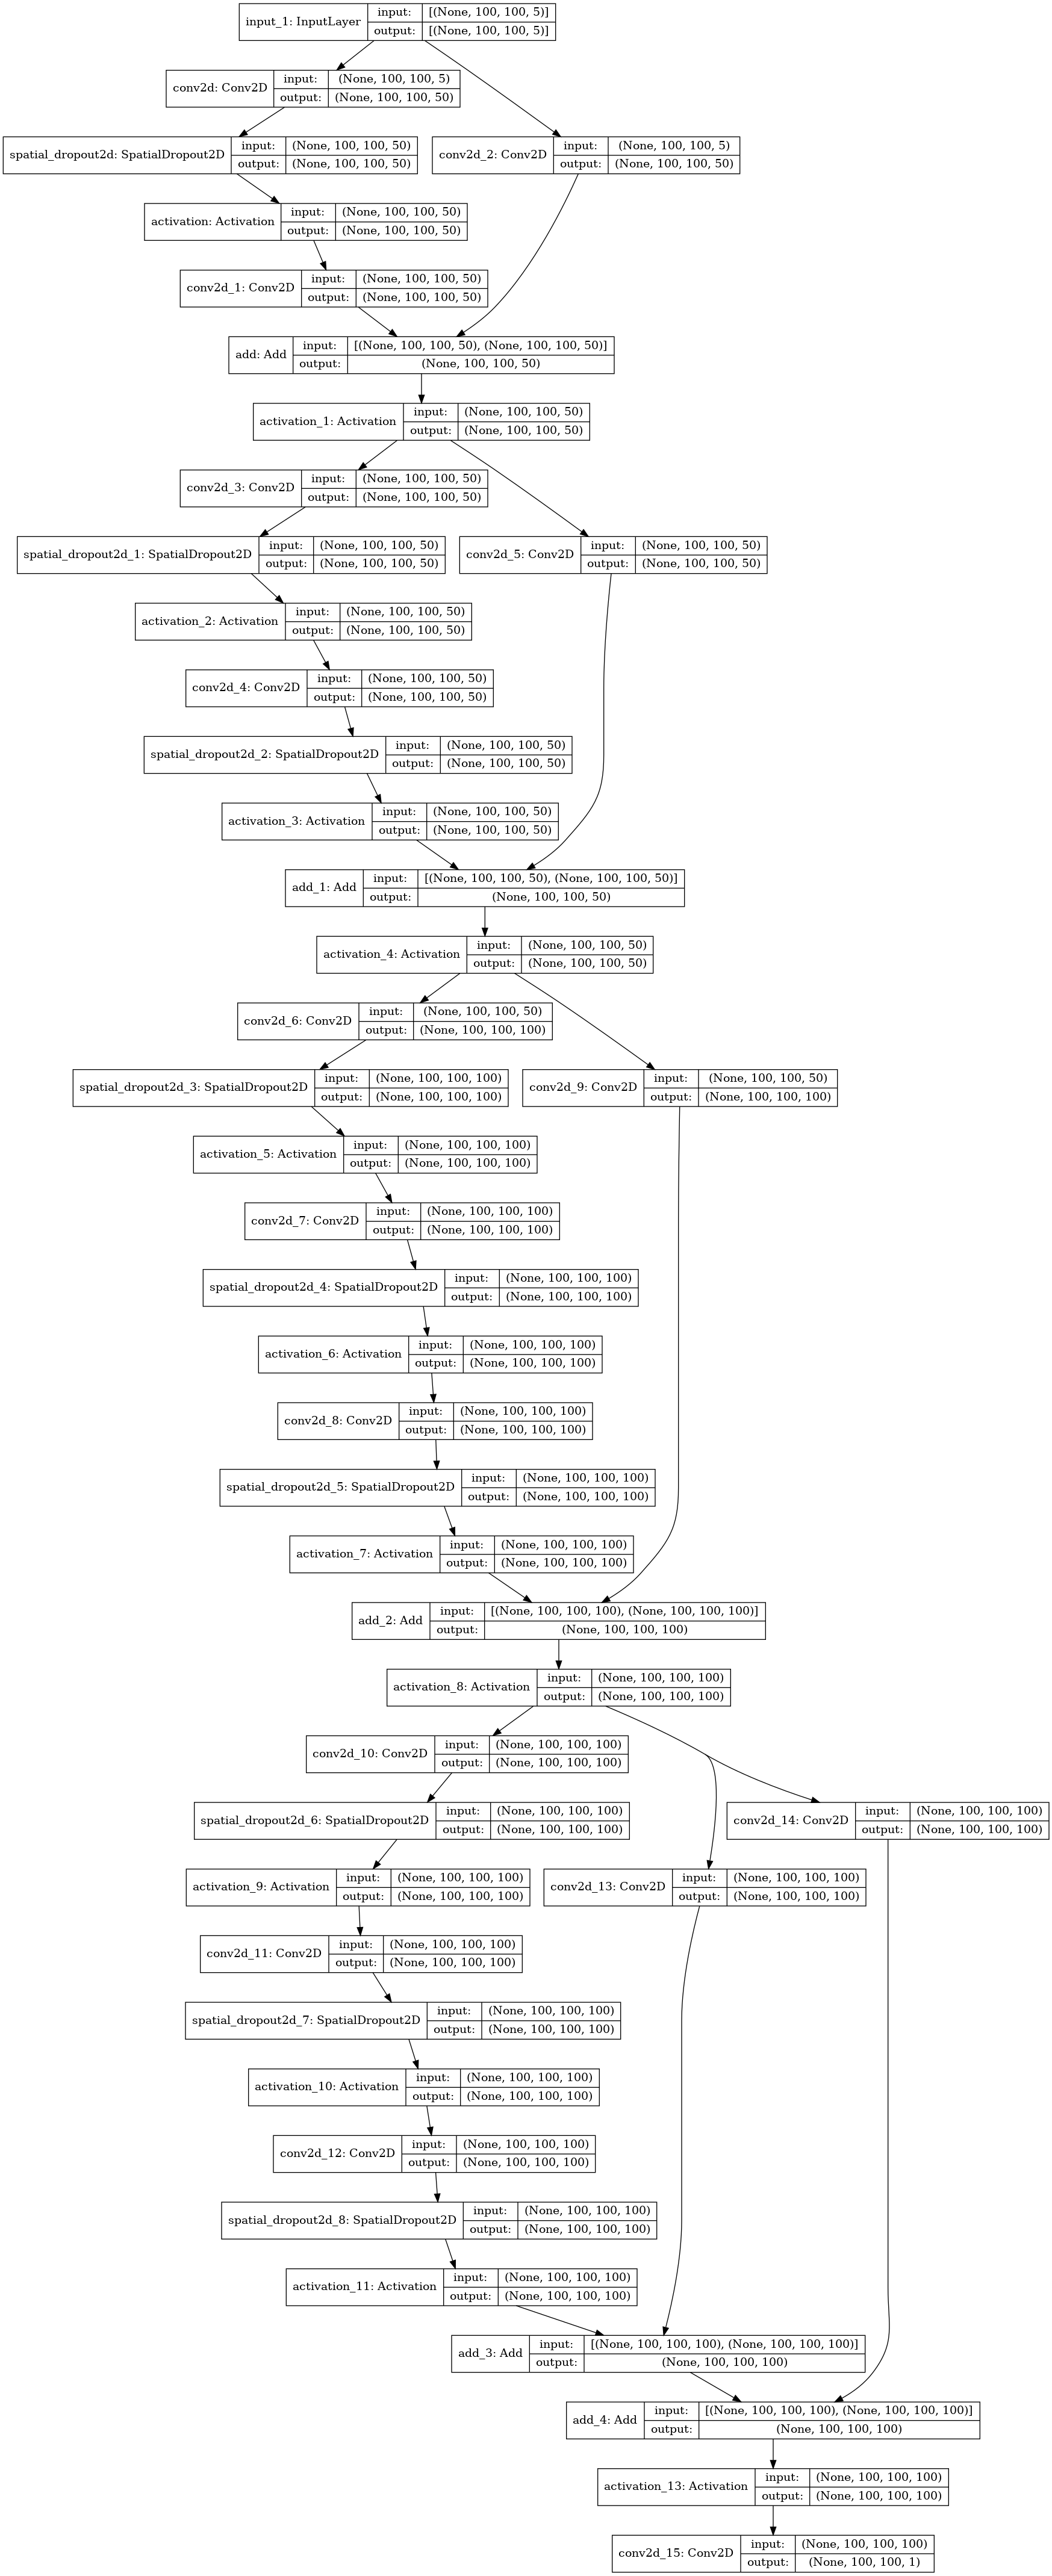

In [10]:
tf.keras.utils.plot_model(model, to_file='../../models/model_grande.png', show_shapes=True)

In [ ]:
batch_size = 20
epochs=5000

print('''
--------------------
(•_•)
<)   )╯ Train-
/   \\

(•_•)
<)   )>  ing 
/   \\ 

 \(•_•)
 (   (>  Beast
 /   \\

  (•_•)
+-)   )-+ Mode!
 /   \\
  
--------------------
''')


#fits the model on batches with real-time data augmentation:
hist = model.fit(
    Xout['train'],
#     steps_per_epoch=int(1.5 * len(Xout['train']) / batch_size),
    epochs=epochs,
    validation_data=(Xout['test'], Yout['test']),
    callbacks=[es, model_save]
)

# hist = model.fit(
#     X['train'],Y['train'],
#     epochs=epochs,
#     validation_data=(X['test'], Y['test']),
#     callbacks=[es, model_save]
# )

print('\n\n')
print('-----------------')

print('-----------------')


--------------------
(•_•)
<)   )╯ Train-
/   \

(•_•)
<)   )>  ing 
/   \ 

 \(•_•)
 (   (>  Beast
 /   \

  (•_•)
+-)   )-+ Mode!
 /   \
  
--------------------

Train on 320 samples, validate on 1280 samples
Epoch 1/5000
320/320 [==============================] - 19s 59ms/sample - loss: 109.7105 - mean_squared_error: 109.7105 - val_loss: 0.2550 - val_mean_squared_error: 0.2550
Epoch 2/5000
320/320 [==============================] - 7s 21ms/sample - loss: 0.8941 - mean_squared_error: 0.8941 - val_loss: 0.2489 - val_mean_squared_error: 0.2489
Epoch 3/5000
320/320 [==============================] - 6s 20ms/sample - loss: 0.2823 - mean_squared_error: 0.2823 - val_loss: 0.7032 - val_mean_squared_error: 0.7032
Epoch 4/5000
320/320 [==============================] - 6s 20ms/sample - loss: 0.1857 - mean_squared_error: 0.1857 - val_loss: 0.7330 - val_mean_squared_error: 0.7330
Epoch 5/5000
320/320 [==============================] - 6s 20ms/sample - loss: 0.1353 - mean_squared_error: 0.1353 

In [13]:
# # ------------------ #
# # Save Model Weights #
# # ------------------ #

# model.save_weights('../../models/model_grande_weights.h5')
# # Save the model architecture
# with open('../../models/model_grande_architecture.json', 'w') as f:
#     f.write(model.to_json())

In [ ]:
# ------------------ #
# Save Model Weights #
# ------------------ #

# serialize model to JSON
model_json = model.to_json()
with open('../../models/model_grande_architecture.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('../../models/model_grande_weights.h5')
print("Saved model to disk")

In [ ]:
Ycal = {}
Ycal['test'] = model.predict(Xout['test']).flatten()
Ycal['test'][Ycal['test'] < 0] = 0
Ycal['train'] = model.predict(Xout['train']).flatten()
Ycal['train'][Ycal['train'] < 0] = 0


print('Train R^2: {0:0.4f}'.format(metrics.r2_score(Yout['train'].flatten(), Ycal['train'].flatten())))
print('Test R^2: {0:.4f}\n'.format(metrics.r2_score(Yout['test'].flatten(), Ycal['test'].flatten())))
# Pearson Correlations -----------------
print('----------------------')
print('Train PearsonCorr: {0:0.2f}'.format(pearsonr(Yout['train'].flatten(), Ycal['train'].flatten())[0]))
print('Test PearsonCorr: {0:.2f}\n'.format(pearsonr(Yout['test'].flatten(), Ycal['test'].flatten())[0]))
print('----------------------')
print(
    'Train RMSE: {0:0.2f}'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['train'].flatten(), Yout['train'].flatten()
            )
        )
    )
)
print(
    'Test RMSE: {0:.2f}\n'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['test'].flatten(), Yout['test'].flatten()
            )
        )
    )
)

### Simpler Model

In [ ]:
def base_model(input_dim):
    model = Sequential()
    model.add(Convolution2D(
        filters=50,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same',
        input_shape=input_dim)
    )
    model.add(Activation('relu'))    
    model.add(Convolution2D(
        filters=60,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=70,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=80,
        kernel_size=(5,5),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    # ---------------------------------------- #
    #            Compile Model                 #
    # ---------------------------------------- #
    model.compile(loss=losses.mean_squared_error,
                  optimizer=Adam(lr=0.0001),
                  metrics=['mse'])
    return model

In [ ]:
# ---------------------------------------- #
#         Call and Fit Model               #
# ---------------------------------------- #
# simple early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)

model_save = ModelCheckpoint(os.path.join('..', 'models', 'best_model.h5'),
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

model = base_model(
    Xout['train'].shape[1:]
)

### Save the Architecture as a Visual

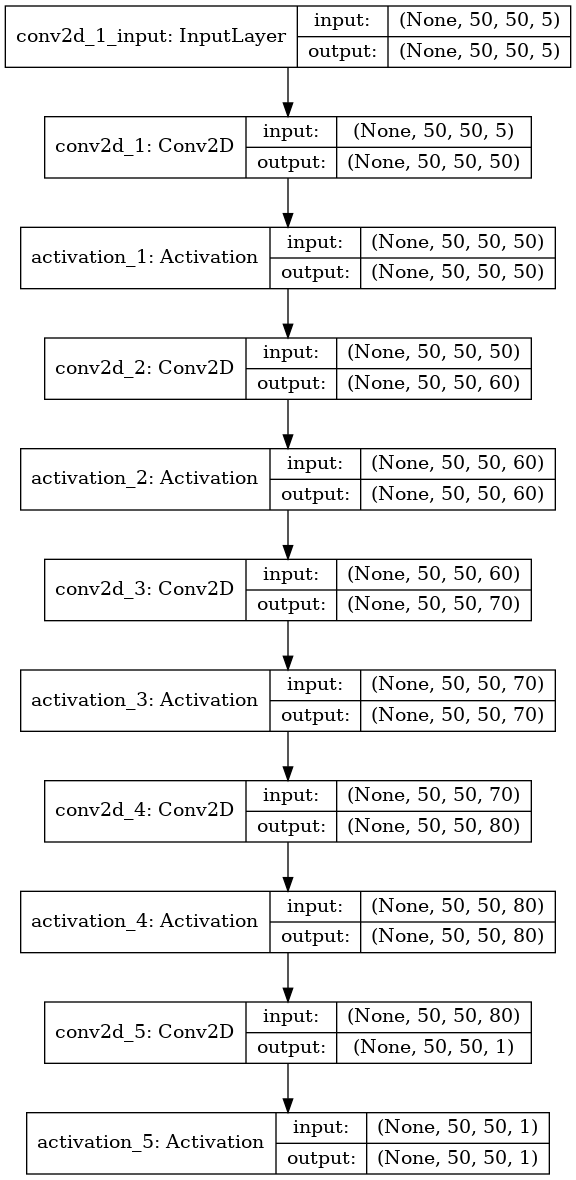

In [51]:
tf.keras.utils.plot_model(model, to_file='../../models/model_chiquito.png', show_shapes=True)

# Apply the fit along with minimal hyperparameter specifications.

In [ ]:
hist = model.fit(
    Xout['train'], Yout['train'],
    epochs=500,
    validation_data=(Xout['test'], Yout['test']),
    batch_size=20,
    verbose=1,
    shuffle=True,
    callbacks=[es]
)
print('\n\n')
print('-----------------')

print('-----------------')

### Save the Model Weights and Architeture

In [ ]:
# ------------------ #
# Save Model Weights #
# ------------------ #

# serialize model to JSON
model_json = model.to_json()
with open('../../models/model_chico_architecture.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('../../models/model_chico_weights.h5')
print("Saved model to disk")

### Model Assessment
```
1. Predict on Test and Train
2. Make all predicted snowdepths < 0 to 0. 
```

In [57]:
Ycal = {}
Ycal['test'] = model.predict(Xout['test']).flatten()
Ycal['test'][Ycal['test'] < 0] = 0
Ycal['train'] = model.predict(Xout['train']).flatten()
Ycal['train'][Ycal['train'] < 0] = 0


### Define the Limits to the Scatter Plot

In [58]:
plot_lims = [np.array([Ycal['test'].min(), Ycal['train'].min(), Yout['train'].min(), Yout['test'].min()]).min(),
            np.array([Ycal['test'].max(), Ycal['train'].max(), Yout['train'].max(), Yout['test'].max()]).max()]

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

# Subplot 1 ----------------
ax1.plot(
    Yout['train'].flatten(),
    Ycal['train'].flatten(),
    '.'
)
ax1.set_aspect('equal')
ax1.title.set_text('Train Set')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Subplot 2 ----------------
ax2.plot(
    Yout['test'].flatten(),
    Ycal['test'].flatten(),
    '.'
)
ax2.title.set_text('Hold Out Set')
ax2.set_aspect('equal')
plt.subplots_adjust(wspace=1, hspace=0.15)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Rsquared Values ----------------
plt.savefig('../../figures/{0}_obs_vs_pred.png'.format(SITENAME))

In [60]:
print('Train R^2: {0:0.4f}'.format(metrics.r2_score(Yout['train'].flatten(), Ycal['train'].flatten())))
print('Test R^2: {0:.4f}\n'.format(metrics.r2_score(Yout['test'].flatten(), Ycal['test'].flatten())))
# Pearson Correlations -----------------
print('----------------------')
print('Train PearsonCorr: {0:0.2f}'.format(pearsonr(Yout['train'].flatten(), Ycal['train'].flatten())[0]))
print('Test PearsonCorr: {0:.2f}\n'.format(pearsonr(Yout['test'].flatten(), Ycal['test'].flatten())[0]))
print('----------------------')
print(
    'Train RMSE: {0:0.2f}'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['train'].flatten(), Yout['train'].flatten()
            )
        )
    )
)
print(
    'Test RMSE: {0:.2f}\n'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['test'].flatten(), Yout['test'].flatten()
            )
        )
    )
)

Train R^2: 0.3411
Test R^2: 0.2605

----------------------
Train PearsonCorr: 0.59
Test PearsonCorr: 0.52

----------------------
Train RMSE: 0.32
Test RMSE: 0.34



In [21]:
st0 = np.random.get_state()

In [22]:
st0

('MT19937', array([2585444518, 3058928920, 1748469878, 3645760037, 1969315984,
         894840732, 4006395061,  118105968, 2805113527, 2865363879,
        1342982330, 3949051127, 2892827990, 2019225877, 2850588073,
        3687330181, 1315075659,  184476471, 1370987272, 3343191312,
        1342902284, 1202770810, 2177466437, 3936575521, 2425170083,
        3841112995, 4064610990, 3202631836,  181568692, 1743015230,
         648844570,  263047969,  341056864, 3917739137,  689888628,
         813537522, 2963043379, 3905397905, 3370702772, 1865423101,
        1427480156, 1823670229, 1241156048,  787821067,  278950664,
         846956918, 2866675910, 2521164048, 3685060236,  223244340,
        1088667005, 1424604109, 3358232432, 1038013437, 1709708383,
        2761192308, 1163795763, 3299113547, 4128332789,  440898085,
         596814666, 3849450893, 2367456005, 3175078442, 1491225256,
        2108784901, 4141118610, 3820892185,  964440891,  833402351,
        1031482164, 4053329005, 33883